# FD001 发动机剩余使用寿命(RUL)预测 - POC 阶段

**项目目标**: 预测测试集中发动机在发生故障前的剩余运行循环数(Remaining Useful Life - RUL)

**数据集**: CMAPSS FD001

- 训练轨迹: 100 个发动机
- 测试轨迹: 100 个发动机
- 工况: 单一工况 (Sea Level)
- 故障模式: 单一故障模式 (HPC Degradation - 高压压缩机退化)

**日期**: 2024 年 10 月 24 日  
**阶段**: Step 1 - Proof of Concept (POC)


## 1. 问题形式化 (Formalisation du problème)

### 1.1 问题定义

这是一个**回归任务**，目标是预测发动机在发生故障前还能运行的循环数(RUL)。

### 1.2 数据结构说明

**训练集特点**：

- 每个发动机从正常状态开始运行
- 随时间推移逐渐退化
- 数据记录到系统故障为止
- 我们可以计算每个时间点的 RUL = max_cycles - current_cycle

**测试集特点**：

- 每个发动机的数据在故障前某个时刻截止
- 我们需要预测从最后记录的 cycle 到故障的剩余循环数
- 真实 RUL 值在 RUL_FD001.txt 中提供用于评估

### 1.3 数据格式

每行包含 26 列：

1. unit_id: 发动机编号
2. time_cycles: 运行周期数
   3-5. operational_setting_1/2/3: 三个操作设置参数
   6-26. sensor_1 到 sensor_21: 21 个传感器测量值

### 1.4 FD001 特性

- **单一工况**: 所有发动机在相同的操作条件下运行（海平面）
- **单一故障模式**: 只有 HPC 退化这一种故障
- 相对简化的场景，适合 POC 快速验证

### 1.5 评估指标

使用**RMSE (Root Mean Square Error)**作为主要评估指标：
$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$


## 2. 数据加载与初步探索


In [81]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 设置可视化样式
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("库导入成功！")


库导入成功！


In [82]:
# 定义列名
# 26列：unit_id, time_cycles, 3个操作设置, 21个传感器
column_names = ['unit_id', 'time_cycles'] + \
               [f'setting_{i}' for i in range(1, 4)] + \
               [f'sensor_{i}' for i in range(1, 22)]

# 数据文件路径
data_path = '../CMAPSSData/'

# 加载训练集
train_df = pd.read_csv(data_path + 'train_FD001.txt', sep='\s+', header=None, names=column_names)

# 加载测试集
test_df = pd.read_csv(data_path + 'test_FD001.txt', sep='\s+', header=None, names=column_names)

# 加载真实RUL值
rul_df = pd.read_csv(data_path + 'RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

print(f"训练集形状: {train_df.shape}")
print(f"测试集形状: {test_df.shape}")
print(f"RUL标签形状: {rul_df.shape}")
print("\n数据加载成功！")


训练集形状: (20631, 26)
测试集形状: (13096, 26)
RUL标签形状: (100, 1)

数据加载成功！


In [83]:
# 查看训练集前几行
print("训练集前5行：")
train_df.head()


训练集前5行：


,unit_id,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [84]:
# 数据基本信息
print("训练集数据信息：")
print(train_df.info())
print("\n" + "="*50 + "\n")

# 检查缺失值
print("训练集缺失值统计：")
print(train_df.isnull().sum().sum())
print("\n测试集缺失值统计：")
print(test_df.isnull().sum().sum())


训练集数据信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_id      20631 non-null  int64  
 1   time_cycles  20631 non-null  int64  
 2   setting_1    20631 non-null  float64
 3   setting_2    20631 non-null  float64
 4   setting_3    20631 non-null  float64
 5   sensor_1     20631 non-null  float64
 6   sensor_2     20631 non-null  float64
 7   sensor_3     20631 non-null  float64
 8   sensor_4     20631 non-null  float64
 9   sensor_5     20631 non-null  float64
 10  sensor_6     20631 non-null  float64
 11  sensor_7     20631 non-null  float64
 12  sensor_8     20631 non-null  float64
 13  sensor_9     20631 non-null  float64
 14  sensor_10    20631 non-null  float64
 15  sensor_11    20631 non-null  float64
 16  sensor_12    20631 non-null  float64
 17  sensor_13    20631 non-null  float64
 18  sensor_14    20631 non-null  float64


In [85]:
# 为训练集计算RUL (Remaining Useful Life)
# RUL = 每个发动机的最大cycle数 - 当前cycle数

# 计算每个发动机的最大cycle
max_cycles = train_df.groupby('unit_id')['time_cycles'].max().reset_index()
max_cycles.columns = ['unit_id', 'max_cycle']

# 合并回训练集
train_df = train_df.merge(max_cycles, on='unit_id', how='left')

# 计算RUL
train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']

# 删除辅助列
train_df = train_df.drop('max_cycle', axis=1)

print("训练集RUL计算完成！")
print(f"\nRUL统计信息：")
print(train_df['RUL'].describe())


训练集RUL计算完成！

RUL统计信息：
count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64


## 3. 探索性数据分析 (EDA)

### 3.1 发动机生命周期分析


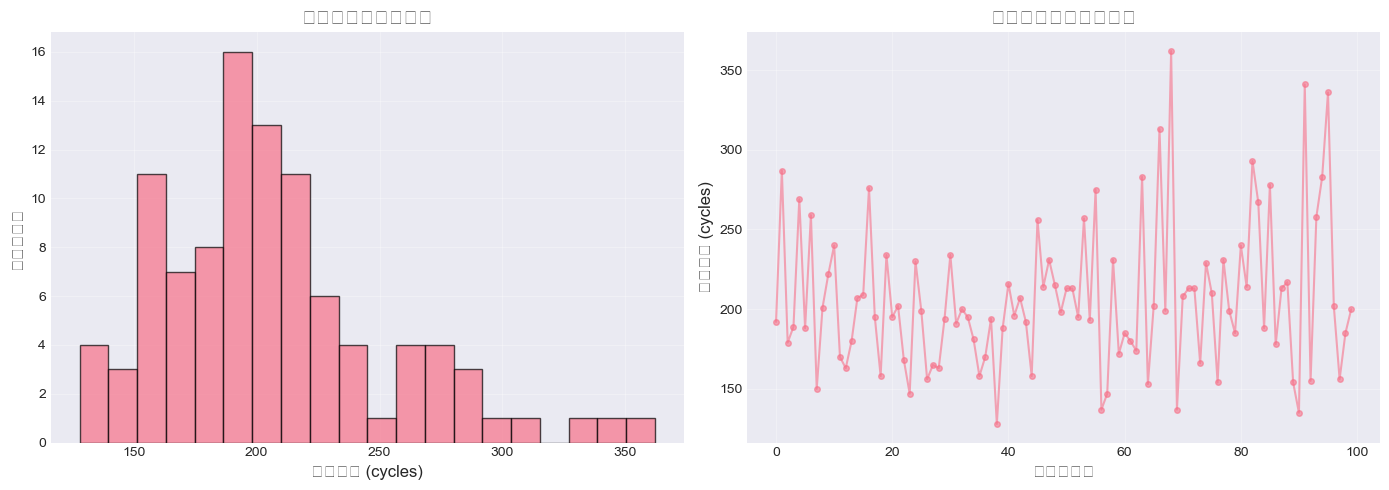

生命周期统计：
  最小值: 128 cycles
  最大值: 362 cycles
  平均值: 206.31 cycles
  中位数: 199.00 cycles


In [86]:
# 查看每个发动机的生命周期长度
engine_life = train_df.groupby('unit_id')['time_cycles'].max()

plt.figure(figsize=(14, 5))

# 子图1：生命周期分布
plt.subplot(1, 2, 1)
plt.hist(engine_life, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('生命周期 (cycles)', fontsize=12)
plt.ylabel('发动机数量', fontsize=12)
plt.title('发动机生命周期分布', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 子图2：每个发动机的生命周期
plt.subplot(1, 2, 2)
plt.plot(engine_life.values, marker='o', linestyle='-', markersize=4, alpha=0.6)
plt.xlabel('发动机编号', fontsize=12)
plt.ylabel('生命周期 (cycles)', fontsize=12)
plt.title('各发动机生命周期对比', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"生命周期统计：")
print(f"  最小值: {engine_life.min()} cycles")
print(f"  最大值: {engine_life.max()} cycles")
print(f"  平均值: {engine_life.mean():.2f} cycles")
print(f"  中位数: {engine_life.median():.2f} cycles")


### 3.2 操作设置 (Operational Settings) 分析

**说明**: FD001 是单一工况数据集，预期 3 个操作设置应该是常量或变化很小


In [87]:
# 检查操作设置的统计信息
setting_cols = ['setting_1', 'setting_2', 'setting_3']

print("操作设置统计信息：\n")
for col in setting_cols:
    unique_vals = train_df[col].nunique()
    std_val = train_df[col].std()
    print(f"{col}:")
    print(f"  唯一值数量: {unique_vals}")
    print(f"  标准差: {std_val:.6f}")
    print(f"  范围: [{train_df[col].min():.6f}, {train_df[col].max():.6f}]")
    print()

print("\n结论: 由于FD001是单一工况，这些设置列变化极小，可以考虑删除")


操作设置统计信息：

setting_1:
  唯一值数量: 158
  标准差: 0.002187
  范围: [-0.008700, 0.008700]

setting_2:
  唯一值数量: 13
  标准差: 0.000293
  范围: [-0.000600, 0.000600]

setting_3:
  唯一值数量: 1
  标准差: 0.000000
  范围: [100.000000, 100.000000]


结论: 由于FD001是单一工况，这些设置列变化极小，可以考虑删除


### 3.3 传感器数据分析

**目标**:

- 识别常量传感器（方差为 0 或极小）
- 查看传感器随时间的退化趋势
- 分析传感器与 RUL 的相关性


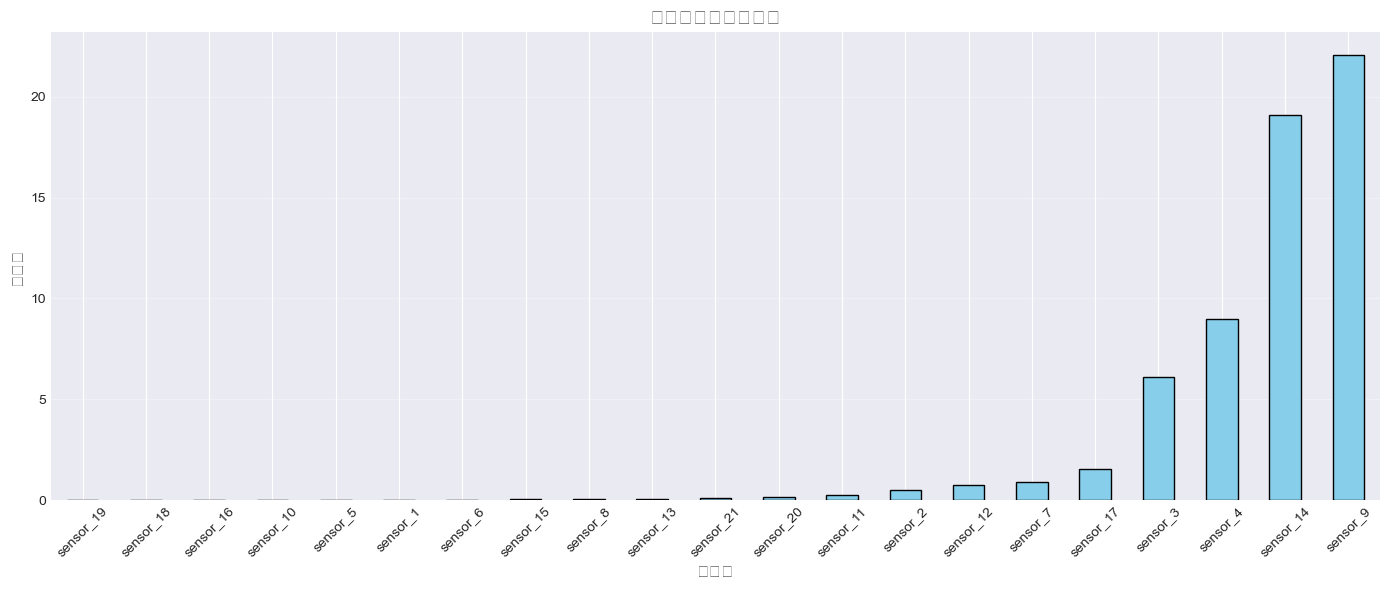


方差极小的传感器 (标准差 < 0.01): ['sensor_19', 'sensor_18', 'sensor_16', 'sensor_10', 'sensor_5', 'sensor_1', 'sensor_6']
数量: 7

这些传感器由于变化极小，不包含有用信息，可以删除


In [88]:
# 识别常量传感器（方差极小的列）
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]

# 计算每个传感器的标准差
sensor_std = train_df[sensor_cols].std().sort_values()

# 可视化
plt.figure(figsize=(14, 6))
sensor_std.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('传感器', fontsize=12)
plt.ylabel('标准差', fontsize=12)
plt.title('各传感器标准差分布', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# 识别方差极小的传感器（标准差 < 0.01）
constant_sensors = sensor_std[sensor_std < 0.01].index.tolist()
print(f"\n方差极小的传感器 (标准差 < 0.01): {constant_sensors}")
print(f"数量: {len(constant_sensors)}")

print(f"\n这些传感器由于变化极小，不包含有用信息，可以删除")


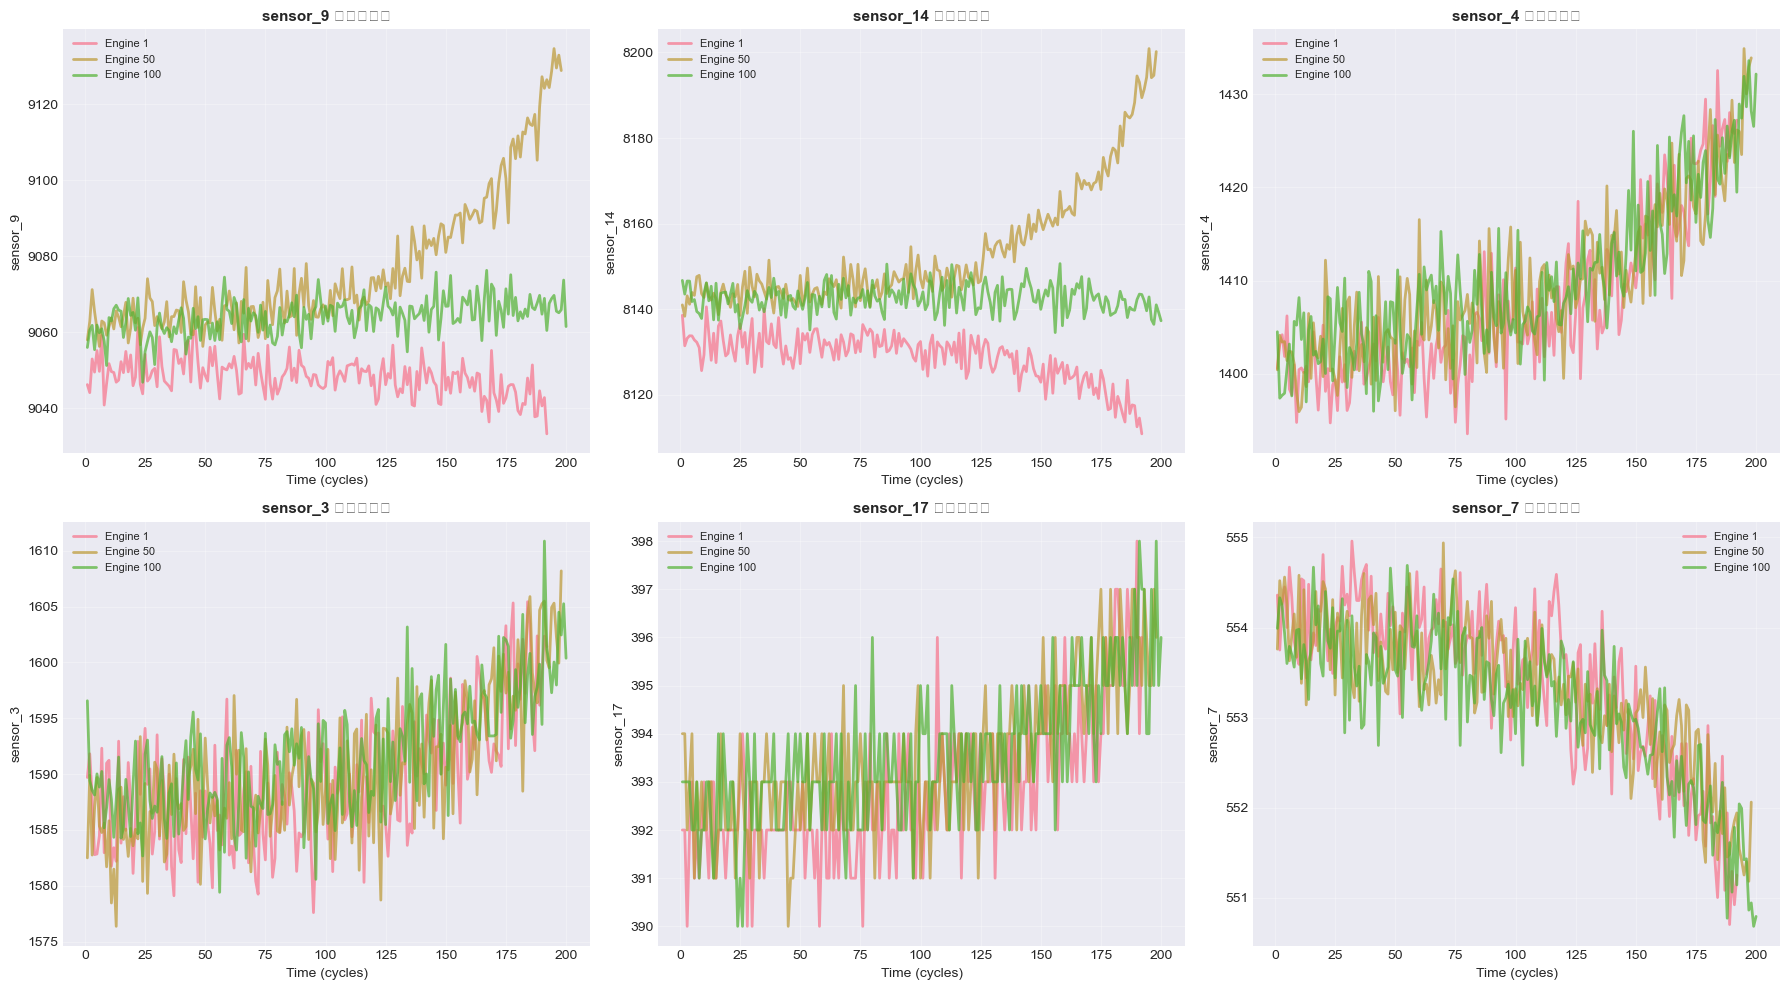

可视化了标准差最大的6个传感器的退化趋势
观察: 部分传感器显示明显的退化模式，这对RUL预测很有价值


In [89]:
# 可视化几个代表性发动机的传感器退化趋势
# 选择标准差较大的传感器（更可能包含退化信息）
top_sensors = sensor_std.nlargest(6).index.tolist()

# 选择3个代表性发动机
selected_engines = [1, 50, 100]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, sensor in enumerate(top_sensors):
    ax = axes[idx]
    for engine_id in selected_engines:
        engine_data = train_df[train_df['unit_id'] == engine_id]
        ax.plot(engine_data['time_cycles'], engine_data[sensor], 
                label=f'Engine {engine_id}', alpha=0.7, linewidth=2)
    
    ax.set_xlabel('Time (cycles)', fontsize=10)
    ax.set_ylabel(sensor, fontsize=10)
    ax.set_title(f'{sensor} 随时间变化', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"可视化了标准差最大的6个传感器的退化趋势")
print(f"观察: 部分传感器显示明显的退化模式，这对RUL预测很有价值")


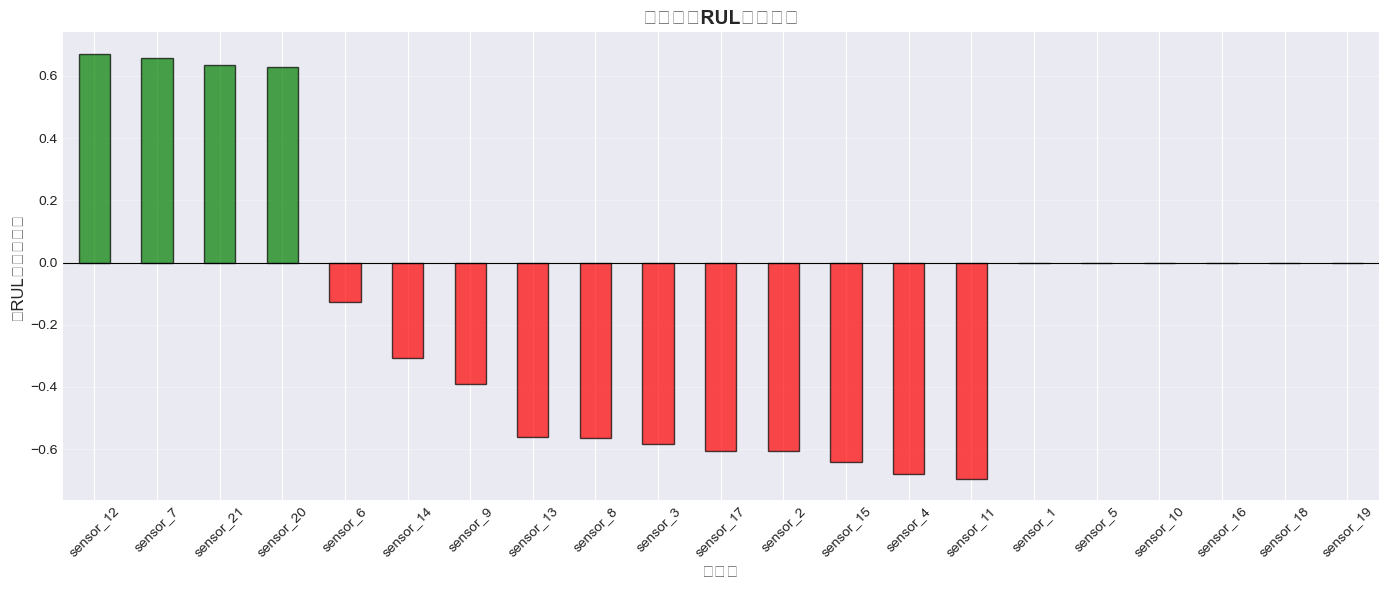


与RUL相关性最强的传感器（绝对值）：
sensor_11    0.696228
sensor_4     0.678948
sensor_12    0.671983
sensor_7     0.657223
sensor_15    0.642667
sensor_21    0.635662
sensor_20    0.629428
sensor_2     0.606484
sensor_17    0.606154
sensor_3     0.584520
Name: RUL, dtype: float64

分析: 某些传感器与RUL有较强的相关性（正相关或负相关），这些是关键特征


In [90]:
# 分析传感器与RUL的相关性
correlation_with_rul = train_df[sensor_cols + ['RUL']].corr()['RUL'].drop('RUL').sort_values(ascending=False)

plt.figure(figsize=(14, 6))
correlation_with_rul.plot(kind='bar', color=['green' if x > 0 else 'red' for x in correlation_with_rul], 
                          edgecolor='black', alpha=0.7)
plt.xlabel('传感器', fontsize=12)
plt.ylabel('与RUL的相关系数', fontsize=12)
plt.title('传感器与RUL的相关性', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n与RUL相关性最强的传感器（绝对值）：")
print(correlation_with_rul.abs().sort_values(ascending=False).head(10))

print("\n分析: 某些传感器与RUL有较强的相关性（正相关或负相关），这些是关键特征")


## 4. 预处理实现

### 4.1 特征选择

**策略**:

- 删除操作设置列（FD001 单一工况，变化极小）
- 删除常量传感器（方差极小的传感器）
- 保留有用的传感器数据


In [91]:
# 定义要删除的列
cols_to_drop = setting_cols + constant_sensors

print(f"准备删除的列: {cols_to_drop}")
print(f"删除列数量: {len(cols_to_drop)}")

# 创建训练和测试数据的副本
train_processed = train_df.copy()
test_processed = test_df.copy()

# 删除不需要的列
train_processed = train_processed.drop(cols_to_drop, axis=1)
test_processed = test_processed.drop(cols_to_drop, axis=1)

print(f"\n处理后训练集形状: {train_processed.shape}")
print(f"处理后测试集形状: {test_processed.shape}")

# 显示保留的列
feature_cols = [col for col in train_processed.columns if col not in ['unit_id', 'time_cycles', 'RUL']]
print(f"\n保留的特征列数量: {len(feature_cols)}")
print(f"特征列: {feature_cols}")


准备删除的列: ['setting_1', 'setting_2', 'setting_3', 'sensor_19', 'sensor_18', 'sensor_16', 'sensor_10', 'sensor_5', 'sensor_1', 'sensor_6']
删除列数量: 10

处理后训练集形状: (20631, 17)
处理后测试集形状: (13096, 16)

保留的特征列数量: 14
特征列: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']


### 4.2 数据归一化

**原因**:

- 不同传感器的量纲和范围差异很大
- 归一化可以提高模型性能和训练速度
- 使用 MinMaxScaler 将数据缩放到[0, 1]区间


In [92]:
# 初始化MinMaxScaler
scaler = MinMaxScaler()

# 在训练集上拟合scaler
scaler.fit(train_processed[feature_cols])

# 对训练集和测试集进行归一化
train_processed[feature_cols] = scaler.transform(train_processed[feature_cols])
test_processed[feature_cols] = scaler.transform(test_processed[feature_cols])

print("数据归一化完成！")
print(f"\n归一化后的数据范围示例（前5个特征）：")
print(train_processed[feature_cols[:5]].describe())


数据归一化完成！

归一化后的数据范围示例（前5个特征）：
           sensor_2      sensor_3      sensor_4      sensor_7      sensor_8
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.000000
mean       0.443052      0.424746      0.450435      0.566459      0.297957
std        0.150618      0.133664      0.151935      0.142527      0.107554
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.335843      0.331807      0.339467      0.476651      0.227273
50%        0.430723      0.415522      0.435348      0.578100      0.287879
75%        0.539157      0.508829      0.545324      0.669887      0.363636
max        1.000000      1.000000      1.000000      1.000000      1.000000


### 4.3 准备训练和测试数据

**训练策略改进**:

- **使用所有时间点的数据**（而非仅最后一点）
- 原因：
  - 只用最后一个点会导致训练样本太少（仅 100 个）
  - 缺乏数据多样性，模型无法学习退化模式
  - 所有时间点提供完整的退化轨迹信息
- 这样可以获得约 20,000 个训练样本，大大提高模型性能

**测试策略**:

- 对测试集，使用每个发动机最后一个时间点
- 预测对应的 RUL 值（这是实际应用场景）

**改进空间**:

- 未来可以使用滑动窗口方法
- 考虑 RUL 截断（如上限 125 cycles）
- 添加时序特征（趋势、变化率等）


In [93]:
# ============================================================
# 训练数据策略修改：使用所有时间点，而不只是最后一个点
# ============================================================
# 原因：只用每个发动机的最后一个点会导致：
#   - 训练样本太少（只有100个样本）
#   - 缺乏数据多样性
#   - 特征重要性无法正确计算
# 
# 新策略：使用所有时间点的数据
# ============================================================

print("="*60)
print("准备训练和测试数据")
print("="*60)

# 为训练集：使用所有时间点
X_train_full = train_processed[feature_cols]
y_train_full = train_processed['RUL']

print(f"\n训练数据统计：")
print(f"  总样本数: {len(X_train_full)}")
print(f"  发动机数量: {train_processed['unit_id'].nunique()}")
print(f"  特征数量: {len(feature_cols)}")
print(f"  RUL范围: [{y_train_full.min()}, {y_train_full.max()}]")

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"\n数据划分：")
print(f"  训练集大小: {X_train.shape}")
print(f"  验证集大小: {X_val.shape}")

# 为测试集：取每个发动机的最后一个时间点
test_last = test_processed.groupby('unit_id').last().reset_index()
X_test = test_last[feature_cols]
y_test = rul_df['RUL'].values

print(f"\n测试集：")
print(f"  测试集大小: {X_test.shape}")
print(f"  测试标签大小: {y_test.shape}")
print(f"  RUL范围: [{y_test.min()}, {y_test.max()}]")

print("\n✓ 数据准备完成！")
print("="*60)


准备训练和测试数据

训练数据统计：
  总样本数: 20631
  发动机数量: 100
  特征数量: 14
  RUL范围: [0, 361]

数据划分：
  训练集大小: (16504, 14)
  验证集大小: (4127, 14)

测试集：
  测试集大小: (100, 14)
  测试标签大小: (100,)
  RUL范围: [7, 145]

✓ 数据准备完成！


## 5. 模型训练与评估

### 5.1 模型选择

**POC 阶段选择**:

- **Random Forest**: 作为基准模型，稳定且易于解释
- **XGBoost**: 通常在结构化数据上表现优秀

**为什么选择这些模型**:

- 不需要复杂的特征工程
- 训练速度快，适合 POC
- 对非线性关系有良好的拟合能力
- 未来可以尝试 LSTM 等深度学习模型来利用时序信息


### 5.2 Random Forest 模型


In [94]:
# 训练Random Forest模型
print("="*60)
print("训练 Random Forest 模型...")
print("="*60)

# 检查数据准备情况
print(f"\n数据检查:")
print(f"  训练集特征形状: {X_train.shape}")
print(f"  训练集标签形状: {y_train.shape}")
print(f"  验证集特征形状: {X_val.shape}")
print(f"  测试集特征形状: {X_test.shape}")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print(f"\n开始训练...")
rf_model.fit(X_train, y_train)
print("✓ 模型训练完成！")

# 在验证集上预测
print("\n进行预测...")
y_val_pred_rf = rf_model.predict(X_val)

# 在测试集上预测
y_test_pred_rf = rf_model.predict(X_test)
print("✓ 预测完成！")

# 计算评估指标
val_rmse_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
val_mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
val_r2_rf = r2_score(y_val, y_val_pred_rf)

test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("\n" + "="*60)
print("=== Random Forest 结果 ===")
print("="*60)
print(f"\n【验证集性能】")
print(f"  RMSE: {val_rmse_rf:.2f} cycles")
print(f"  MAE:  {val_mae_rf:.2f} cycles")
print(f"  R²:   {val_r2_rf:.4f}")
print(f"\n【测试集性能】")
print(f"  RMSE: {test_rmse_rf:.2f} cycles")
print(f"  MAE:  {test_mae_rf:.2f} cycles")
print(f"  R²:   {test_r2_rf:.4f}")
print("\n" + "="*60)


训练 Random Forest 模型...

数据检查:
  训练集特征形状: (16504, 14)
  训练集标签形状: (16504,)
  验证集特征形状: (4127, 14)
  测试集特征形状: (100, 14)

开始训练...
✓ 模型训练完成！

进行预测...
✓ 预测完成！

=== Random Forest 结果 ===

【验证集性能】
  RMSE: 41.31 cycles
  MAE:  29.48 cycles
  R²:   0.6265

【测试集性能】
  RMSE: 33.12 cycles
  MAE:  24.24 cycles
  R²:   0.3646




特征重要性分析


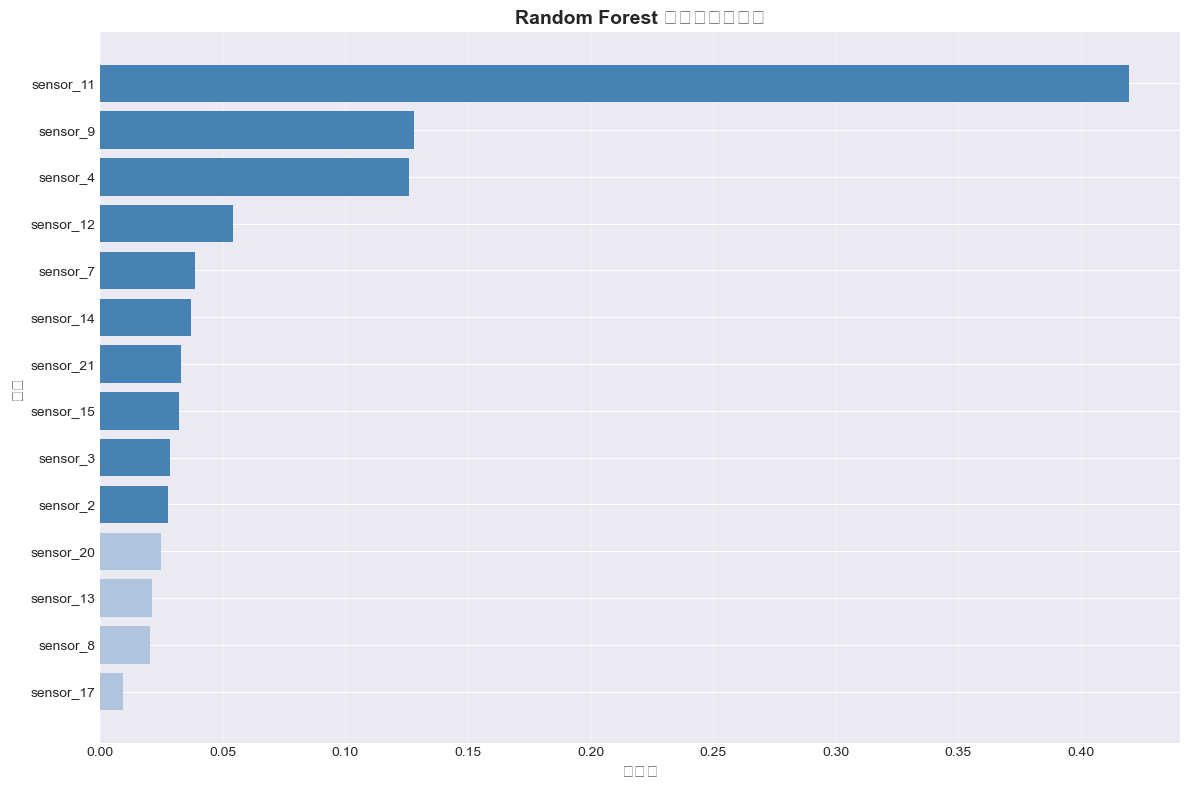


✓ Top 10 最重要特征：
----------------------------------------
  sensor_11    : 0.4195
  sensor_9     : 0.1280
  sensor_4     : 0.1260
  sensor_12    : 0.0542
  sensor_7     : 0.0385
  sensor_14    : 0.0371
  sensor_21    : 0.0329
  sensor_15    : 0.0321
  sensor_3     : 0.0285
  sensor_2     : 0.0277

分析：
  - 深蓝色条代表Top 10最重要特征
  - 这些传感器对RUL预测贡献最大
  - 未来可以重点分析这些传感器的退化模式


In [95]:
# 特征重要性分析
print("\n" + "="*60)
print("特征重要性分析")
print("="*60)

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# 可视化所有特征的重要性
plt.figure(figsize=(12, 8))
colors = ['steelblue' if i < 10 else 'lightsteelblue' for i in range(len(feature_importance))]
plt.barh(range(len(feature_importance)), feature_importance['importance'], color=colors)
plt.yticks(range(len(feature_importance)), feature_importance['feature'], fontsize=10)
plt.xlabel('重要性', fontsize=12, fontweight='bold')
plt.ylabel('特征', fontsize=12, fontweight='bold')
plt.title('Random Forest 特征重要性排名', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 显示Top 10最重要特征
print("\n✓ Top 10 最重要特征：")
print("-" * 40)
for idx, row in feature_importance.head(10).iterrows():
    print(f"  {row['feature']:12s} : {row['importance']:.4f}")

print("\n分析：")
print("  - 深蓝色条代表Top 10最重要特征")
print("  - 这些传感器对RUL预测贡献最大")
print("  - 未来可以重点分析这些传感器的退化模式")


### 5.3 XGBoost 模型

XGBoost 是一个高性能的梯度提升模型，通常在结构化数据上表现优秀。


In [96]:
# 尝试导入XGBoost
try:
    import xgboost as xgb
    xgboost_available = True
    print("XGBoost 可用")
except ImportError:
    xgboost_available = False
    print("XGBoost 未安装，将跳过XGBoost模型")
    print("可以使用: pip install xgboost 来安装")


XGBoost 未安装，将跳过XGBoost模型
可以使用: pip install xgboost 来安装


In [97]:
if xgboost_available:
    # 训练XGBoost模型
    print("\n训练 XGBoost 模型...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=7,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    xgb_model.fit(X_train, y_train)
    
    # 在验证集上预测
    y_val_pred_xgb = xgb_model.predict(X_val)
    
    # 在测试集上预测
    y_test_pred_xgb = xgb_model.predict(X_test)
    
    # 计算评估指标
    val_rmse_xgb = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb))
    val_mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
    val_r2_xgb = r2_score(y_val, y_val_pred_xgb)
    
    test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
    test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
    test_r2_xgb = r2_score(y_test, y_test_pred_xgb)
    
    print("\n=== XGBoost 结果 ===")
    print(f"验证集 RMSE: {val_rmse_xgb:.2f}")
    print(f"验证集 MAE: {val_mae_xgb:.2f}")
    print(f"验证集 R²: {val_r2_xgb:.4f}")
    print(f"\n测试集 RMSE: {test_rmse_xgb:.2f}")
    print(f"测试集 MAE: {test_mae_xgb:.2f}")
    print(f"测试集 R²: {test_r2_xgb:.4f}")
else:
    print("\n跳过XGBoost模型训练")



跳过XGBoost模型训练


### 5.4 预测结果可视化


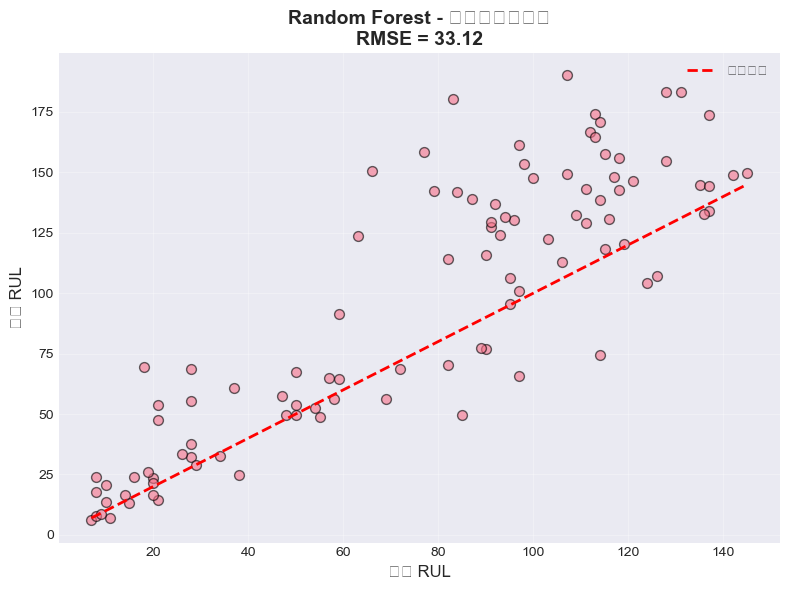

In [98]:
# 可视化测试集预测结果
if xgboost_available:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Random Forest
    axes[0].scatter(y_test, y_test_pred_rf, alpha=0.6, s=50, edgecolor='black')
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 'r--', lw=2, label='理想预测')
    axes[0].set_xlabel('真实 RUL', fontsize=12)
    axes[0].set_ylabel('预测 RUL', fontsize=12)
    axes[0].set_title(f'Random Forest\nRMSE = {test_rmse_rf:.2f}', 
                      fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # XGBoost
    axes[1].scatter(y_test, y_test_pred_xgb, alpha=0.6, s=50, color='green', edgecolor='black')
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 'r--', lw=2, label='理想预测')
    axes[1].set_xlabel('真实 RUL', fontsize=12)
    axes[1].set_ylabel('预测 RUL', fontsize=12)
    axes[1].set_title(f'XGBoost\nRMSE = {test_rmse_xgb:.2f}', 
                      fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    # 只有Random Forest
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred_rf, alpha=0.6, s=50, edgecolor='black')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='理想预测')
    plt.xlabel('真实 RUL', fontsize=12)
    plt.ylabel('预测 RUL', fontsize=12)
    plt.title(f'Random Forest - 测试集预测结果\nRMSE = {test_rmse_rf:.2f}', 
              fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


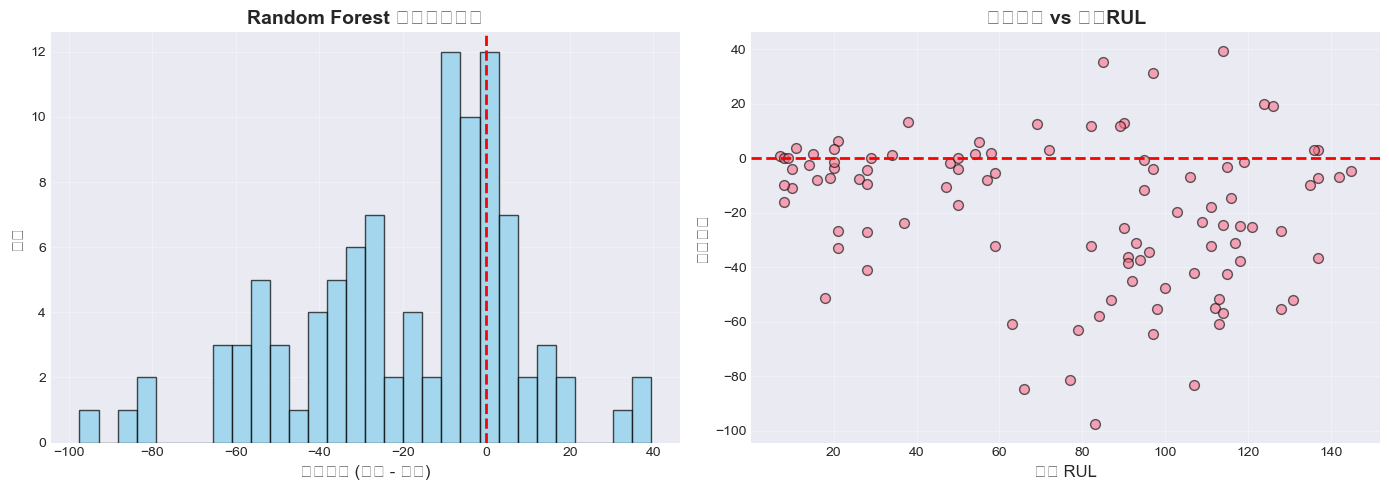


误差统计：
  平均误差: -19.34
  误差标准差: 26.90
  最大正误差（高估）: 39.41
  最大负误差（低估）: -97.44


In [99]:
# 误差分析
errors_rf = y_test - y_test_pred_rf

plt.figure(figsize=(14, 5))

# 子图1：误差分布
plt.subplot(1, 2, 1)
plt.hist(errors_rf, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('预测误差 (真实 - 预测)', fontsize=12)
plt.ylabel('频数', fontsize=12)
plt.title('Random Forest 预测误差分布', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# 子图2：误差 vs 真实RUL
plt.subplot(1, 2, 2)
plt.scatter(y_test, errors_rf, alpha=0.6, s=50, edgecolor='black')
plt.xlabel('真实 RUL', fontsize=12)
plt.ylabel('预测误差', fontsize=12)
plt.title('预测误差 vs 真实RUL', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n误差统计：")
print(f"  平均误差: {errors_rf.mean():.2f}")
print(f"  误差标准差: {errors_rf.std():.2f}")
print(f"  最大正误差（高估）: {errors_rf.max():.2f}")
print(f"  最大负误差（低估）: {errors_rf.min():.2f}")


## 6. 结果总结与改进方向

### 6.1 POC 总结


In [100]:
# 模型性能对比总结
print("="*60)
print("POC 阶段完成 - 模型性能总结")
print("="*60)

print("\n【Random Forest】")
print(f"  测试集 RMSE: {test_rmse_rf:.2f} cycles")
print(f"  测试集 MAE:  {test_mae_rf:.2f} cycles")
print(f"  测试集 R²:   {test_r2_rf:.4f}")

if xgboost_available:
    print("\n【XGBoost】")
    print(f"  测试集 RMSE: {test_rmse_xgb:.2f} cycles")
    print(f"  测试集 MAE:  {test_mae_xgb:.2f} cycles")
    print(f"  测试集 R²:   {test_r2_xgb:.4f}")
    
    if test_rmse_xgb < test_rmse_rf:
        print(f"\n✓ XGBoost 表现更好，RMSE降低了 {test_rmse_rf - test_rmse_xgb:.2f} cycles")
    else:
        print(f"\n✓ Random Forest 表现更好，RMSE降低了 {test_rmse_xgb - test_rmse_rf:.2f} cycles")

print("\n" + "="*60)


POC 阶段完成 - 模型性能总结

【Random Forest】
  测试集 RMSE: 33.12 cycles
  测试集 MAE:  24.24 cycles
  测试集 R²:   0.3646



### 6.2 当前方法的优点与局限

#### ✅ 优点

1. **快速验证可行性**: 在 POC 阶段快速建立 baseline 模型
2. **简单有效**: Random Forest 模型表现稳定，无需复杂调参
3. **可解释性**: 通过特征重要性分析，了解哪些传感器最关键
4. **数据清洗合理**: 成功识别并删除了无用的常量列

#### ⚠️ 局限

1. **忽略时序信息**: 只使用最后一个时间点，没有利用完整的退化序列
2. **简单特征工程**: 没有提取滚动统计、趋势等高级特征
3. **未优化超参数**: 使用默认或简单的参数设置
4. **训练数据有限**: 每个发动机只用一个数据点，损失了大量信息


### 6.3 改进方向 (Step 2 的工作)

#### 🔧 特征工程增强

1. **滑动窗口统计特征**
   - 计算过去 N 个 cycles 的均值、标准差、最大值、最小值
   - 提取传感器变化率和趋势信息
2. **传感器组合特征**

   - 创建传感器之间的比值、差值等交互特征
   - 基于物理意义的特征组合

3. **退化指标**
   - 计算传感器相对于初始状态的退化程度
   - 提取非线性退化模式

#### 🧠 模型改进

1. **时序模型**

   - **LSTM/GRU**: 更好地捕捉时间序列的长期依赖
   - **1D-CNN**: 提取局部时序模式
   - **Transformer**: 建模复杂的时序关系

2. **训练策略优化**

   - 使用所有时间点而非仅最后一点
   - 实现 sliding window 方法增加训练样本
   - 考虑 RUL 截断（如 RUL 上限设为 125，避免早期 cycle 的影响）

3. **超参数调优**

   - 使用网格搜索或贝叶斯优化
   - 交叉验证确保模型稳定性

4. **集成方法**
   - 结合多个模型的预测（Random Forest + XGBoost + LSTM）
   - Stacking 或 Blending 策略

#### 📊 深入分析

1. **传感器相关性深度分析**

   - 研究传感器之间的因果关系
   - 识别冗余传感器

2. **异常检测与数据清洗**

   - 识别并处理传感器异常值
   - 处理可能的传感器故障数据

3. **不同退化阶段的建模**
   - 早期、中期、晚期使用不同的特征或模型
   - 分段建模策略

#### 🎯 评估改进

1. **自定义评分函数**

   - NASA 使用的评分函数（对晚预测（低估 RUL）惩罚更重）
   - 考虑实际应用中的成本函数

2. **更全面的评估**
   - 不同 RUL 范围的性能分析
   - 鲁棒性测试


### 6.4 结论

本 POC 成功地：

1. ✅ **验证了问题的可行性**: FD001 数据集上的 RUL 预测是可行的
2. ✅ **建立了 baseline**: Random Forest 模型提供了一个稳定的性能基准
3. ✅ **识别了关键特征**: 通过 EDA 和特征重要性分析，了解了哪些传感器最重要
4. ✅ **明确了改进方向**: 为 Step 2 的深入工作指明了方向

**下一步工作重点**：

- 实现更复杂的特征工程（滑动窗口、趋势特征）
- 尝试时序深度学习模型（LSTM）
- 优化模型超参数
- 使用所有时间点数据而非仅最后一点

---

**提交信息**:

- 数据集: FD001
- 完成日期: 2024 年 10 月 24 日
- 阶段: Step 1 - POC
- 下一步: Step 2 深度优化
